# 04. PyTorch Customs Datasets 

We've used some datasets before, but how do you get your own data into PyTorch?

One of the ways is via: custom datasets 

## Domain libraries 

Depending on what you are working with (vision, text, ...) you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.


## 0. Importing PyTorch and setting up device-agnostic code 

In [103]:
import torch 
from torch import nn

# Note: we need PyTorch 1.10.0+ for the course
print(f"PyTorch version: {torch.__version__}")

device = "cuda" if torch.cuda.is_available else "cpu"
print(f"Device available: {device}")

PyTorch version: 1.13.1+cu117
Device available: cuda


In [104]:
!nvidia-smi

Sat Sep  6 14:14:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.64.03              Driver Version: 575.64.03      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   38C    P8              2W /   55W |      11MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Get data 

Our dataset is a subset of the Food101 dataset

Food101 starts with 101 different classes of food and 1000 images per class (~750 training, ~250 testing)

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, ~25 testing)

In machine learing it's important to start with a small scale to experiment faster.

In [105]:
import requests 
import zipfile 
from pathlib import Path

# Setup path to a data folder
data_path = Path(".data/")
image_path = data_path/"pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it ...
if image_path.is_dir():
    print(f"'{image_path}' directory alredy exists, skipping this step")
else:
    print(f"'{image_path}' doest not exist, creating one ...")
    image_path.mkdir(parents=True, exist_ok=True)
    
# Download  
with open(data_path/"pizza_steak_sushi.zip","wb") as f: # This creates also de zipfile 
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak and sushi data ...")
    f.write(request.content)
    
# Unzip data
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref: 
    print("Unzipping pizza, steak and sushi data ...")
    zip_ref.extractall(image_path)

'.data/pizza_steak_sushi' directory alredy exists, skipping this step
Unzipping pizza, steak and sushi data ...


## 2. Becoming one with the data (data preparation and exploration)

In [106]:
import os 
def walk_through_dir(dir_path):
    '''Walks through dir_path returning its contents.'''
    
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [107]:
walk_through_dir(image_path)

There are 2 directories and 0 images in '.data/pizza_steak_sushi'
There are 3 directories and 0 images in '.data/pizza_steak_sushi/train'
There are 0 directories and 75 images in '.data/pizza_steak_sushi/train/steak'
There are 0 directories and 72 images in '.data/pizza_steak_sushi/train/sushi'
There are 0 directories and 78 images in '.data/pizza_steak_sushi/train/pizza'
There are 3 directories and 0 images in '.data/pizza_steak_sushi/test'
There are 0 directories and 19 images in '.data/pizza_steak_sushi/test/steak'
There are 0 directories and 31 images in '.data/pizza_steak_sushi/test/sushi'
There are 0 directories and 25 images in '.data/pizza_steak_sushi/test/pizza'


### 2.1 Visualizing an image

1. Get all of the images paths
2. Pick a random image path using Pythons's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images let's open the image with Python's PIL
5. We'll then show the image and print metadata 

.data/pizza_steak_sushi/train/sushi/3107839.jpg
sushi
Random image path: .data/pizza_steak_sushi/train/sushi/3107839.jpg
Image class: sushi
Image height: 384
Image width: 512


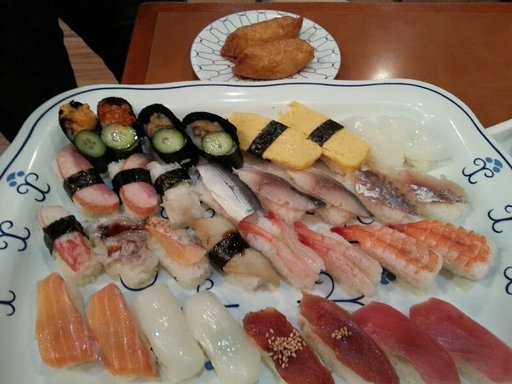

In [108]:
import random 
from PIL import Image

# Set seed if needed
#random.seed(42)

# 1. Get all images paths 
image_path_list = list(image_path.glob("*/*/*.jpg")) # First start for train/test, second for the label and third for the image name

# 2. Pick a random image path 
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name 
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

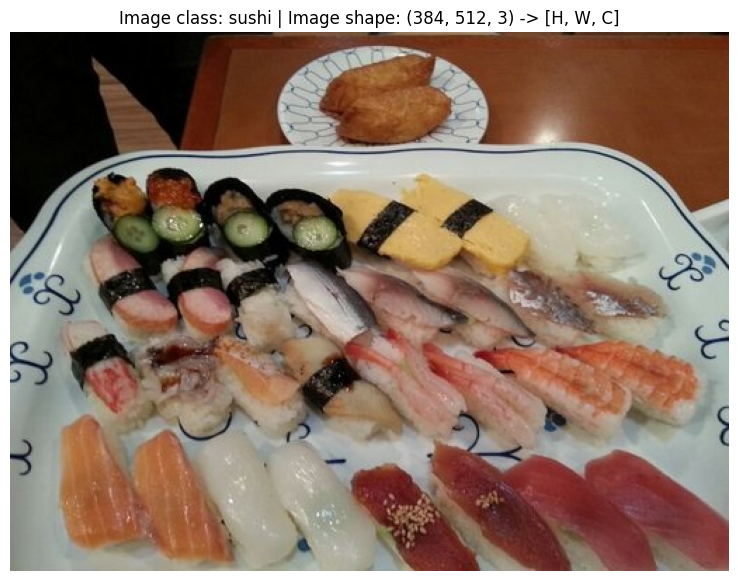

In [109]:
import matplotlib.pyplot as plt 
import numpy as np

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot image
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [H, W, C]")
plt.axis(False)
plt.show()

# Note: [H, W, C] is the default for matplotlib and pill
# Rembember: for PyTorch the default is [C, H, W]

## 3 Transforming data

Before we can use our image data with PyTorch: 

1. Turn your target data into tensors (numerical representation).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.Dataloader`, we'll call these `dataset`and `dataloader`.


In [110]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

#### 3.1 Transforming data wiht `torchvision.transform`

In [111]:
# Write a transform for image 
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizintal to add randomness 
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch tensor 
    transforms.ToTensor()   
]) 
# Note: To do more than 1 transfrom you can use .Compose() or nn.Sequential()

In [112]:
tmp = data_transform(img)
tmp.shape, tmp.dtype

(torch.Size([3, 64, 64]), torch.float32)

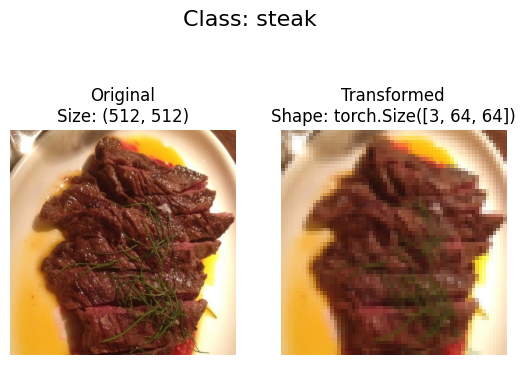

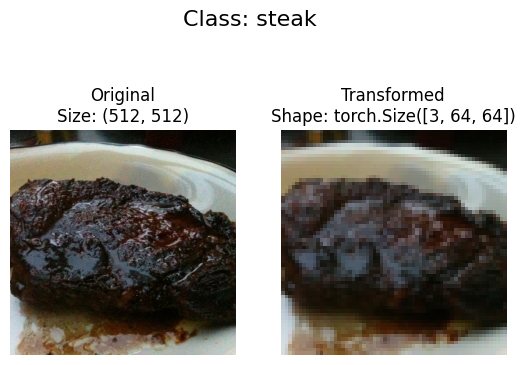

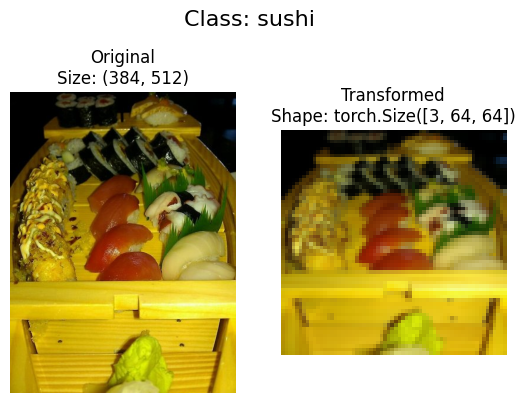

In [113]:
def plot_transformed_images(image_paths: list, transform, n: int = 3, seed: int = 42):
    '''
    Selects random images from a path of images and loads/transforms 
    them then plots the original vs the transformed.
    '''
    
    # Set the seed 
    if seed:
        random.seed(42)
    
    # Sample n images paths (one path per img)
    random_image_paths = random.sample(image_paths, k=n)
    
    # Loop for every path 
    for image_path in random_image_paths:
         with Image.open(image_path) as f:
             fig, ax = plt.subplots(nrows = 1, ncols = 2)
             
             # Original image
             ax[0].imshow(f)
             ax[0].set_title(f"Original\nSize: {f.size}")
             ax[0].axis(False)
             
             # Transform and plot target image
             transformed_image = transform(f) # note that we'll need to change shape for matplotlib 
             ax[1].imshow(transformed_image.permute((1,2,0))) # Change shape from CHW (PyTorch) for HWC (matplotlib formate)
             ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
             ax[1].axis(False)
             
             fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
             
plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)
             
    

## 4. Option 1: Loading image data using `torchvision.datasets.ImageFolder`

This function works with the saved data format: `root/classX/img.Y`


In [114]:
# Create train_dir and test_dir 
train_dir = image_path/"train"
test_dir = image_path/"test"

In [115]:
# Use ImageFolder to create a dataset 
from torchvision import datasets 
train_data = datasets.ImageFolder(root=train_dir, 
                                  transform=data_transform, # Transform for the data
                                  target_transform=None)    # Transform for the target/label

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: .data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: .data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [116]:
# Get class names as a list 
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [117]:
# Get class names as a diccionary 
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [118]:
# Check lenght of our dataset
len(train_data), len(test_data)

(225, 75)

In [119]:
train_data.samples[0][0]

'.data/pizza_steak_sushi/train/pizza/1008844.jpg'

In [120]:
# Index on the train dataset to get a single image and label 
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> CHW (PyTorch format)
Permuted shape: torch.Size([64, 64, 3]) -> HWC (matplotlib format)


Text(0.5, 1.0, 'Class: pizza')

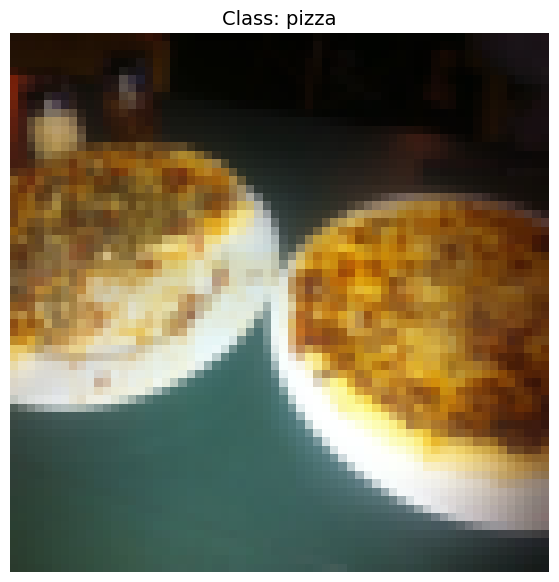

In [121]:
# Rearrange the order dimensions
img_permute = img.permute(1,2,0)

# Print out differents shape
print(f"Original shape: {img.shape} -> CHW (PyTorch format)\nPermuted shape: {img_permute.shape} -> HWC (matplotlib format)")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(f"Class: {class_names[label]}", fontsize=14)